# SPEC Detector tuning of H2RG
## Images in /sdata600/spec_night/04dec18
## nirspec_data/spec_characterization/spec_night/04dec18 on local machine

We ran an overnight script on the SPEC detector in a series of configurations to measure dark current and read noise

In [49]:
#import modules
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import glob
from scipy.stats import linregress

In [47]:
# import data
# fowler plot frames are: 90 sec exposure, MCDS, varying numreads
# 4-13 numreads=1
# 14-23 nr=2
# 24-33 nr=4
# 34-43 nr=8
# 44-53 nr=16
# 54-63 nr=32

# dark current frames are: 
# 44-53: 90 sec, nr=16
# 64-73: 300 sec, nr=16
# 74-83: 600 sec, nr=16
# 84-93: 1200 sec, nr=16
# 94-103: 1800 sec, nr=16

files=sorted(glob.glob('/users/emartin/nirspec_data/spec_characterization/spec_night/04dec18/*.fits'))
fowler=files[3:63]
dark=files[43:53]+files[63:103]
g=2.15

# Read noise tests

In [31]:
def readnoise(im):
    hdu=fits.open(im)
    data=hdu[0].data
    nreads=hdu[0].header['NUMREADS']
    #get standard deviation using median
    x=data
    sd=np.sqrt(np.median(np.abs(x-np.median(x))**2))
    rn=sd*g
    return nreads, rn

In [39]:
reads=[]
rn=[]

for f in fowler:
    n, r = readnoise(f)
    reads.append(n)
    rn.append(r)

reads=np.array(reads)   
rn=np.array(rn)

numreads=[1,2,4,8,16,32]
rn_avg=[]
rn_std=[]

#get average readnoise for each numread
for n in numreads:
    i=np.where(reads==n)[0]
    rn_avg.append(np.median(rn[i]))
    rn_std.append(np.std(rn[i]))
    


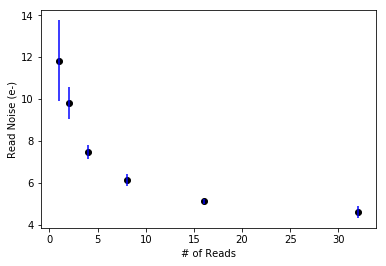

In [62]:
plt.errorbar(numreads, rn_avg, yerr=rn_std, ecolor='b', linestyle='none')
plt.scatter(numreads, rn_avg, color='k')
plt.xlabel('# of Reads')
plt.ylabel('Read Noise (e-)')
plt.savefig('/users/emartin/nirspec_upgrade/plots/fowler_plot_04dec18.pdf')
plt.show()

# Dark Current Tests

In [56]:
def darkcurrent(im):
    hdu=fits.open(im)
    data=hdu[0].data[10:200, 10:200]
    itime=hdu[0].header['RDITIME']
    #sigma clip the image, only use 
    x=data.flatten()
    med=np.median(x)
    sd=np.sqrt(np.median(np.abs(x-med)**2))
    w=np.where(np.abs(x-med) > 3*sd)
    
    x_cut=np.delete(x,w)
    
    dc=np.median(x_cut)*g
    
    return itime, dc

In [57]:
med_counts=[]
time=[]
for i in (dark):
    t,d = darkcurrent(i)
    time.append(t)
    med_counts.append(d)

med_counts=np.array(med_counts)
time=np.array(time)

#fit line to scatter
slope, intercept, r_value, p_value, std_err = linregress(time, med_counts)

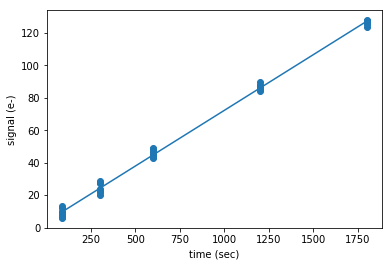

In [61]:
plt.scatter(time, med_counts)
plt.plot(time, slope*time + intercept)
plt.xlabel('time (sec)')
plt.ylabel('signal (e-)')
plt.savefig('/users/emartin/nirspec_upgrade/plots/dark_current_04dec18.pdf')
plt.show()

In [59]:
slope

0.06865292218994305